## Training code for MnM-MOL

In [1]:
import os, torch, time
import json
from torch import optim
import numpy as np
import torch.nn as nn
import torch.autograd as autograd

from tqdm import tqdm
from datetime import datetime
from scipy.io import savemat
from skimage.metrics import peak_signal_noise_ratio, structural_similarity

from mri import sense
from local_lipschitz import LocalLipschitzMasked
from solvers import *
from data_builder import preload, preprocess

import matplotlib.pyplot as plt
from misc import *
device = torch.device("cuda")

#### Load training settings

In [2]:
ts = TrainSettings("mnm-mol_settings.json")

# update dict of global variables with settings, very poor practice but very convenient
globals().update(ts.__dict__)

timestamp = datetime.now()
save_dir = models_dir + timestamp.strftime("%b%d_%H%M") + f'_{num_sub}sub_{num_sl}sl_{net_type}'

print(f"Saving to {save_dir}")

log_every_N_epochs = 1
save_model_every_N_epochs = training_epochs // 5
ts.save_model_every_N_epochs, ts.log_every_N_epochs = save_model_every_N_epochs, log_every_N_epochs

if not(os.path.exists(save_dir)):
    os.makedirs(save_dir)
    
log_fname = save_dir + "/log.txt"

writeLog('\n'+'*'*40, log_fname)
writeLog(f'Training started on {timestamp.strftime("%d-%b-%Y at %I:%M %P")}', log_fname)
writeLog(f'{save_dir}\n', log_fname)

Settings loaded from mnm-mol_settings.json
Saving to models/Mar20_1901_1sub_20sl_mnm-mol

****************************************
Training started on 20-Mar-2024 at 07:01 pm
models/Mar20_1901_1sub_20sl_mnm-mol



#### Define loss functions

The loss function for MnM-MOL is defined as:

$\min_{\theta}~\sum_{k=0}^{N_t} \|\mathbf x^*(k) - \mathbf x(k)\|_2^2 +  \beta ~{\rm ReLU}\big(L\left[\mathcal H_{\theta}(\mathbf x^*(k))\right]-T\big)^2$

This loss is the sum of two terms, an MSE term and a Lipschitz penalty term.

In [3]:
loss_function = nn.MSELoss()

def lipschitz_penalty(x, T):
    condition = (x > T)*torch.tensor(1.0)
    y1 = torch.square(x - T) * condition
    return y1

# Log-barrier penalty should be used instead of the RELU penalty if training MOL
def log_barrier_penalty(x, T, e):
    condition = (x < (T - e))*torch.tensor(1.0)
    y1 = -torch.log((T - x)*condition + (1.0 - condition))    
    y2 = -torch.log(e) + (1/e)*(x - T + e)
    return y1*condition + y2*(1.0 - condition)

#### Setup before training

In [4]:
A_init = sense(cgIter_init).to(device)
A = sense(cgIter_itr).to(device)

solver_block = deGrad

optBlock = solver_block(A, lam_itr, input_channels, number_of_feature_filters, output_channels, number_of_layers)
optBlock.alpha = torch.tensor(alpha, dtype=torch.float32)

model = DEQ(optBlock, nFETarget, A_init, lam_init, tol=err_tol, verbose=False)
model = model.to(device)

if restore:
    model.load_state_dict(torch.load(os.path.join(restore_dir, restore_model))['state_dict'])
    writeLog(f'Weights restored from {restore_dir}', log_fname)

optimizer = optim.Adam([
            {'params': model.f.dw.parameters(), 'lr': learning_rate},
            {'params': model.f.lam, 'lr': learning_rate_lam}
        ])

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.3)

ts.write_json(save_dir + '/settings.json')
lip_threshold = torch.tensor(lip_threshold)
eps = torch.tensor(eps)

best_training_loss = float("inf")
training_loss_epochs, ploss_epochs, closs_epochs = [], [], []
lip_sense_epochs, err_epochs, nFE_epochs, psnr_epochs = [], [], [], []
lip_sense_max_epochs, nFE_max_epochs = [], []

Settings saved to models/Mar20_1901_1sub_20sl_mnm-mol/settings.json


#### Load dataset

In [5]:
org_data, csm_data, mask_data = preload(data_path, num_sub, num_sl, start_sub, start_sl, acc)
org_data, us_data, csm_data, mask_data = preprocess(org_data, csm_data, mask_data)

num_slices = org_data.shape[0]
writeLog(f"Loaded {num_slices} slices", log_fname)

Loading subjects... 1 
Loading masks...
Preprocessing...
Data builder completed

Loaded 20 slices


### Training loop

In [6]:
train_start_time = time.time()
lipschitz_ests_by_slice = dict()

with tqdm(total= training_epochs, position=0, leave=True) as pbar:
    for epoch in range(1,training_epochs+1):       
        
        model.train() # set to training mode
        
        indices = np.random.permutation(num_slices)
        
        training_loss_ep = ploss_ep = closs_ep = 0
        steps_ep = psnr_ep = lip_sense_ep = lip_sense_ep_max = err_ep = nFE_ep = nFE_max_ep = 0.
        
        epoch_start_time = time.time()
        
        for i in indices:
            
            steps_ep = steps_ep + 1
            
            target_fully_sampled = org_data[i:i+1].to(device)
            target_fully_sampled = torch.abs(target_fully_sampled)
            coil_sensitivity_maps = csm_data[i:i+1].to(device)
            input_under_sampled = us_data[i:i+1].to(device)
            mask = mask_data[i:i+1].to(device)
            
            if epoch==1 and i==indices[0]: mem1 = torch.cuda.memory_allocated()
            
            predicted_fully_sampled, sense_out, err, nFE  = model(input_under_sampled, coil_sensitivity_maps, mask)
            
            if epoch==1 and i==indices[0]: writeLog(f"[after forward pass] -- {(torch.cuda.memory_allocated()-mem1)*1e-9:.3f} GB\n", log_fname)
            
            Q = lambda x: optBlock.Q(x,coil_sensitivity_maps,mask) 
            
            u_sense = torch.clone(predicted_fully_sampled).detach().to(device)

            fg_mask = torch.sum(torch.square(coil_sensitivity_maps), dim=1, keepdim=True).abs() > 0
            fg_mask = fg_mask.type(torch.complex64)
            lipf_sense = LocalLipschitzMasked(u_sense, fg_mask, eps, u_sense.shape, Q, lr=learning_rate_lipschitz)
            
            lipf_sense_est = lipf_sense.adverserial_update(iters=adversarial_iters)
            
            if epoch==1: lipschitz_ests_by_slice[int(i)] = list()
            lipschitz_ests_by_slice[int(i)].append(lipf_sense_est.detach().cpu().item())
            
            predicted_fully_sampled = torch.abs(predicted_fully_sampled)
            
            mse_loss = loss_function(predicted_fully_sampled, target_fully_sampled)
            
            clip_loss = clip_wt * lipschitz_penalty(lipf_sense_est, lip_threshold)
        
            loss = mse_loss + clip_loss 
            
            if epoch==1 and i==indices[0]: writeLog(f"[after adversarial iters] -- {(torch.cuda.memory_allocated()-mem1)*1e-9:.3f} GB\n", log_fname)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            if epoch==1 and i==indices[0]: writeLog(f"[after optimizer step] -- {(torch.cuda.memory_allocated()-mem1)*1e-9:.3f} GB\n", log_fname)
                
            training_loss_ep += loss.detach().cpu().item()
            ploss_ep += mse_loss.detach().cpu().item()
            closs_ep += clip_loss.detach().cpu().item()
            
            lip_sense_ep += lipf_sense_est.detach().cpu().item()
            lip_sense_ep_max = max(lipf_sense_est.detach().cpu().item(), lip_sense_ep_max)
            err_ep += err.detach().cpu().item()
            nFE_ep += nFE
            nFE_max_ep = max(nFE, nFE_max_ep)
            
            prediction = np.squeeze(torch.abs(predicted_fully_sampled).detach().cpu().numpy())
            target = np.squeeze(target_fully_sampled.detach().cpu().numpy())
            psnr_ep += peak_signal_noise_ratio(target, prediction, data_range=target.max())    
            
            del lipf_sense_est
            torch.cuda.empty_cache()
            
        epoch_end_time = time.time()
        
        training_loss_epochs.append(training_loss_ep)
        ploss_epochs.append(ploss_ep)
        closs_epochs.append(closs_ep)
        
        lip_sense_epochs.append(lip_sense_ep/steps_ep)
        lip_sense_max_epochs.append(lip_sense_ep_max)
        err_epochs.append(err_ep/steps_ep)
        nFE_epochs.append(nFE_ep/steps_ep)
        nFE_max_epochs.append(nFE_max_ep)
        psnr_epochs.append(psnr_ep/steps_ep)
        
        if (epoch % log_every_N_epochs == 0):
            summary = '[Epoch %d] \ttotal-loss: %.6f, pred-loss: %.6f, clip-loss: %.6f, err: %.5f, lip: %.3f, nAdvrs: %d, λ: %.3f, nFE %d, psnr: %.2f, epoch time: %.2f mins' % (epoch, training_loss_epochs[-1], ploss_epochs[-1], closs_epochs[-1], err_epochs[-1], lip_sense_epochs[-1], adversarial_iters, optBlock.lam.detach().cpu().numpy(), nFE_epochs[-1], psnr_epochs[-1], (epoch_end_time - epoch_start_time)/60)
            pbar.set_description(summary)
            pbar.update(log_every_N_epochs)
            writeLog(summary+"\n", log_fname, mute=True)
            clip_wt = clip_wt*0.97
        
        if np.remainder(epoch, save_model_every_N_epochs)==0:
            save_checkpoint(
                {
                    'epoch': epoch,
                    'state_dict': model.state_dict()
                },
                path=save_dir,
                filename='model.pth.tar'.format(epoch)
            )
            
    pbar.close()
    
train_end_time = time.time()    
writeLog(f"\nTotal time: {round((train_end_time - train_start_time)/60, 2)} mins", log_fname)
writeLog(f"Training completed at {datetime.now().strftime('%d-%b-%Y %I:%M %P')}", log_fname)
writeLog('*'*40, log_fname)

  0%|          | 0/30 [00:00<?, ?it/s]

[after forward pass] -- 0.226 GB

[after adversarial iters] -- 0.455 GB

[after optimizer step] -- 0.010 GB



[Epoch 30] 	total-loss: 0.005662, pred-loss: 0.005662, clip-loss: 0.000000, err: 0.00020, lip: 0.760, nAdvrs: 20, λ: 3.488, nFE 170, psnr: 35.73, epoch time: 0.72 mins: 100%|██████████| 30/30 [21:21<00:00, 42.72s/it]


Total time: 21.36 mins
Training completed at 20-Mar-2024 07:22 pm
****************************************


(4,)


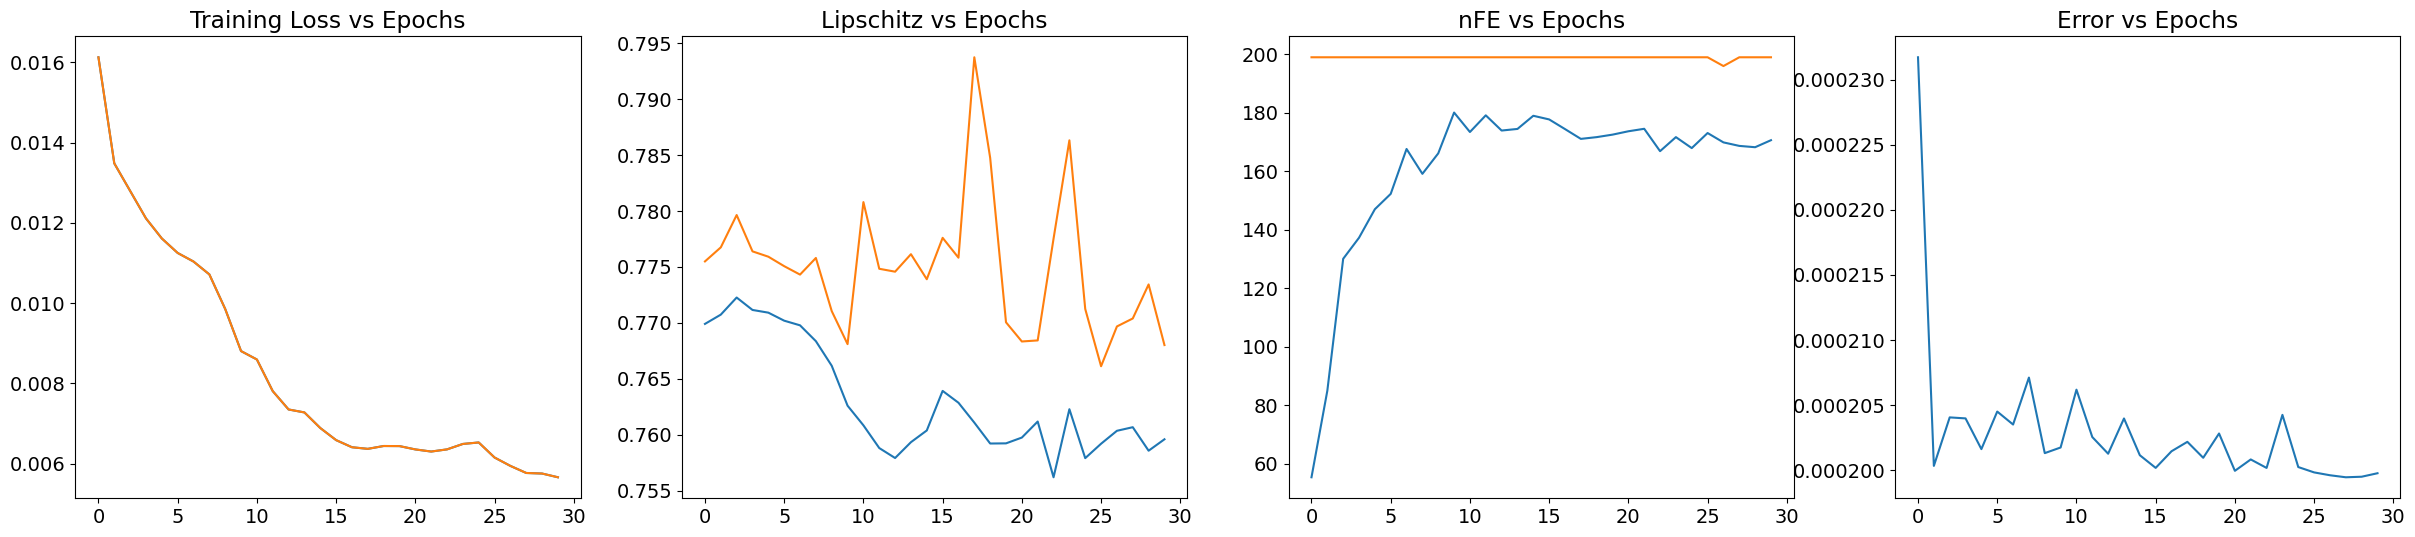

In [7]:
plt.rcParams.update({'font.size': 14})

fig, ax = plt.subplots(1, 4, figsize=(30, 6))
print(ax.shape)
ax[0].plot(training_loss_epochs)
ax[0].plot(ploss_epochs)
ax[0].set_title('Training Loss vs Epochs')
ax[1].plot(lip_sense_epochs)
ax[1].plot(lip_sense_max_epochs)
ax[1].set_title('Lipschitz vs Epochs')
ax[2].plot(nFE_epochs)
ax[2].plot(nFE_max_epochs)
ax[2].set_title('nFE vs Epochs')
ax[3].plot(err_epochs)
ax[3].set_title('Error vs Epochs')

plt.savefig(save_dir+'/train_plots.png')

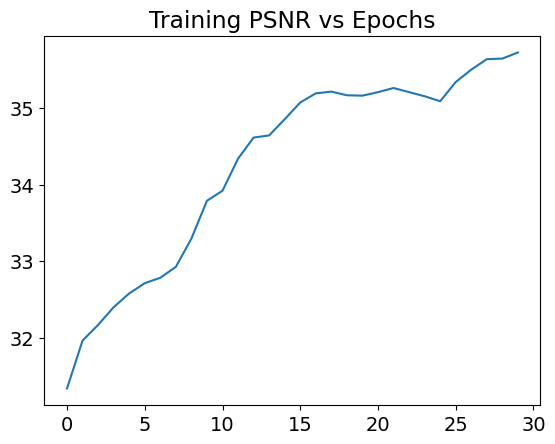

In [8]:
#%% Plot training psnr
plt.figure()
plt.plot(psnr_epochs)
plt.title('Training PSNR vs Epochs')
plt.savefig(save_dir+'/train_psnr.png')

#### Inference on the training data

In [9]:
targets, preds, sense_preds, error_imgs = [], [], [], []
psnr_ins, psnr_outs, ssim_ins, ssim_outs = [], [], [], []

for i in range(num_slices):
    # with torch.no_grad():
    target_fully_sampled, coil_sensitivity_maps, input_under_sampled, mask = org_data[i:i+1].to(device), csm_data[i:i+1].to(device), us_data[i:i+1].to(device), mask_data[i:i+1].to(device)
    target_fully_sampled = torch.abs(target_fully_sampled)

    predicted_fully_sampled, predicted_sense, err, nFE  = model(input_under_sampled, coil_sensitivity_maps, mask)

    prediction = np.squeeze(torch.abs(predicted_fully_sampled).detach().cpu().numpy())
    target = np.squeeze(target_fully_sampled.detach().cpu().numpy())
    inputs = np.squeeze(torch.abs(input_under_sampled).detach().cpu().numpy())
    prediction_sense = np.squeeze(torch.abs(predicted_sense).detach().cpu().numpy())
    err = err.detach().cpu().item()

    torch.cuda.empty_cache()
    
    psnri = peak_signal_noise_ratio(target, prediction_sense, data_range=target.max()) 
    psnrf = peak_signal_noise_ratio(target, prediction, data_range=target.max()) 
    
    ssimi = structural_similarity(target, prediction_sense)
    ssimf = structural_similarity(target, prediction)
    
    error_img = np.abs(target - prediction)
    targets.append(target)
    preds.append(prediction)
    sense_preds.append(prediction_sense)
    error_imgs.append(error_img)
    psnr_ins.append(psnri)
    psnr_outs.append(psnrf)
    ssim_ins.append(ssimi)
    ssim_outs.append(ssimf)

In [10]:
writeLog(f'nFE: {nFE}', log_fname)
writeLog(f'error: {err:.6f}', log_fname)
writeLog(f'SENSE PSNR: {np.mean(psnr_ins):.3f} dB', log_fname)
writeLog(f'MnM-MOL PSNR:   {np.mean(psnr_outs):.3f} dB', log_fname)
writeLog(f'SENSE SSIM: {np.mean(ssim_ins):.3f}', log_fname)
writeLog(f'MnM-MOL SSIM:   {np.mean(ssim_outs):.3f}', log_fname)

nFE: 172
error: 0.000199
SENSE PSNR: 31.795 dB
MnM-MOL PSNR:   35.803 dB
SENSE SSIM: 0.906
MnM-MOL SSIM:   0.960


#### Lipschitz estimate for each training slice

<BarContainer object of 20 artists>

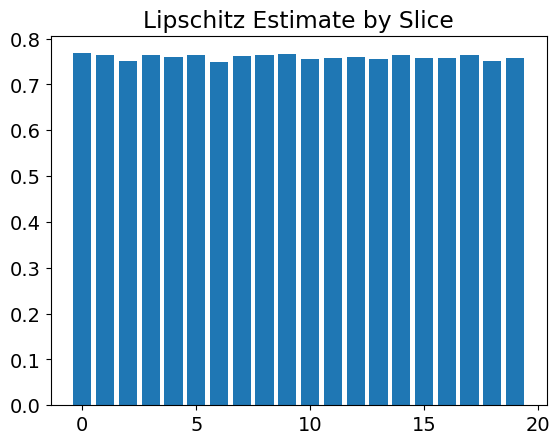

In [11]:
final_lip_by_slice = []
for key, L in lipschitz_ests_by_slice.items():
    final_lip_by_slice.append(L[-1])
    
plt.figure()
plt.title('Lipschitz Estimate by Slice')
plt.bar(np.arange(0, num_slices), final_lip_by_slice)

#### Display reconstructions

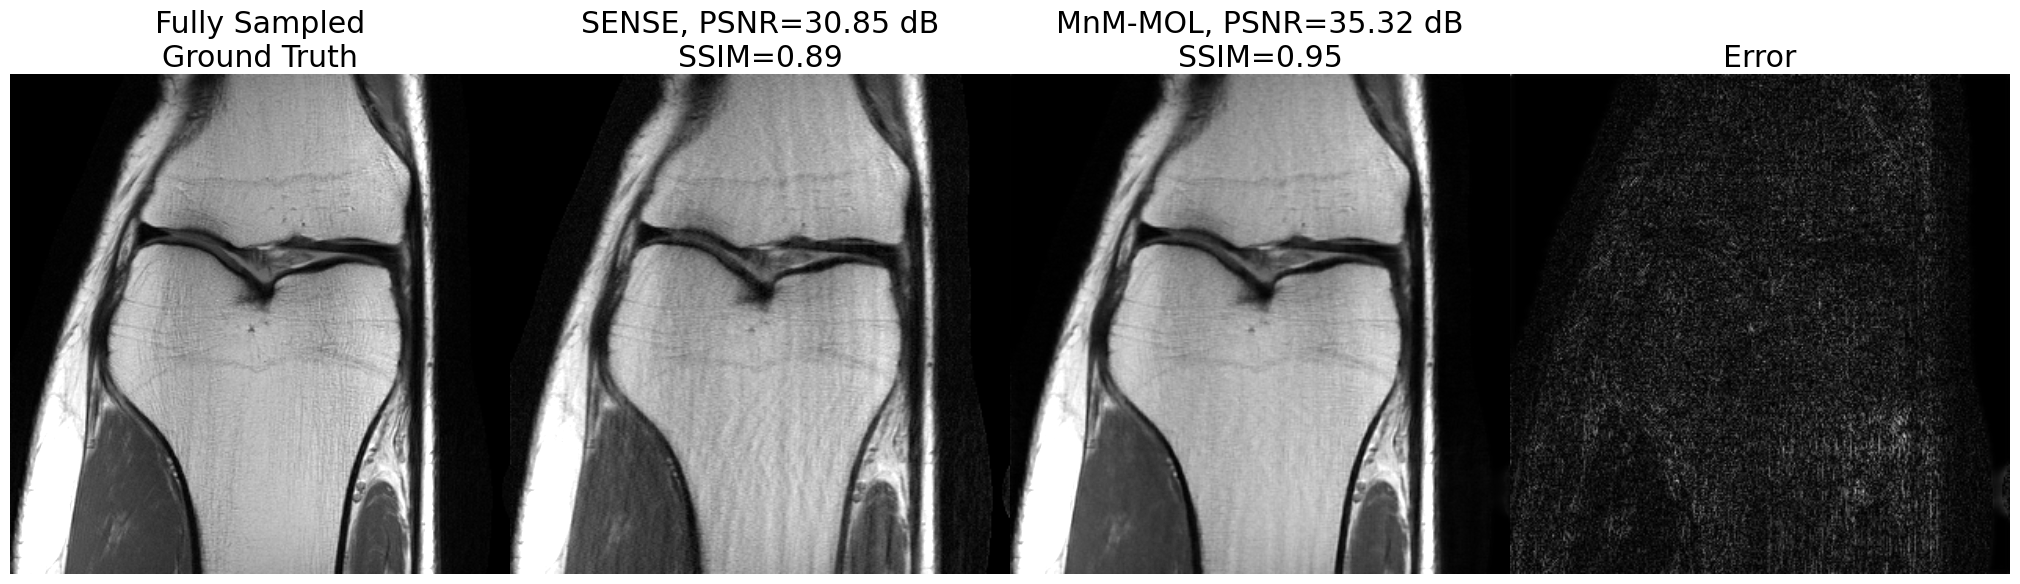

In [12]:
index = 10
plt.rcParams.update({'font.size': 18})
fig, ax = plt.subplots(1, 4, figsize=(20, 10))
def plot(x, i, title="", err=False): 
    if err: 
        ax[i].imshow(x,interpolation='bilinear', cmap=plt.cm.gray, vmax=0.15)
    else:   
        ax[i].imshow(x,interpolation='bilinear',cmap=plt.cm.gray, vmax=0.7)
    ax[i].axis('off')
    ax[i].set_title(title)
    
stco, endco = 0, -1
stro, endro = 0, -1

plot(targets[index][stco:endco,stro:endro], 0, 'Fully Sampled\nGround Truth')

plot(sense_preds[index][stco:endco,stro:endro], 1, f'SENSE, PSNR={psnr_ins[index]:.2f} dB\nSSIM={ssim_ins[index]:.2f}')

plot(preds[index][stco:endco,stro:endro], 2, f'MnM-MOL, PSNR={psnr_outs[index]:.2f} dB\nSSIM={ssim_outs[index]:.2f}')

plot(error_imgs[index][stco:endco,stro:endro], 3, 'Error', err=True)

plt.subplots_adjust(left=0, right=1, top=1, bottom=0, wspace=0.)
plt.savefig(save_dir+f'/train_inference_{index}.png')
plt.show()